In [1]:
import os
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import myServices as ms
import randForest as rfr
import numpy as np
import pandas as pd
import sklearn
import joblib

In [ ]:
# to compute ececution time do:
# with timeit():
#     # your code, e.g., 
class timeit(): 
    from datetime import datetime
    def __enter__(self):
        self.tic = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('runtime: {}'.format(self.datetime.now() - self.tic))

## Random Forest Section

In [ ]:
sklearn.metrics.get_scorer_names()

In [ ]:
print(np.linspace(28,60, 19).astype(int))

In [2]:
DS = pd.read_csv('basin1_FaccNorm.csv', index_col = None)

In [3]:
DS.describe()

,percentage,disToRiv,TWI,TPI,slope,elevation,FAcc_norm
count,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06
mean,9.201795e-02,2.084064e+02,9.483515e+00,-3.328848e-04,4.821367e+00,1.453463e+02,6.924467e-04
std,6.610626e-01,1.713850e+02,4.081659e+00,1.949152e-01,4.994698e+00,4.569706e+01,1.642044e-02
min,0.000000e+00,0.000000e+00,-9.252120e+00,-7.461320e+00,4.700000e-04,-3.685000e-02,0.000000e+00
25%,0.000000e+00,7.382411e+01,5.553190e+00,-6.226000e-02,1.600760e+00,1.157656e+02,1.017589e-06
50%,0.000000e+00,1.677051e+02,1.025636e+01,-2.700000e-04,3.192175e+00,1.481632e+02,4.189410e-06
75%,0.000000e+00,3.010399e+02,1.289330e+01,6.091000e-02,6.192805e+00,1.797259e+02,1.974245e-05
max,5.000000e+00,1.349713e+03,2.486353e+01,6.706970e+00,7.002943e+01,2.605691e+02,1.000000e+00


In [4]:
DS['FAcc_norm_2'] = ms.logTransformation(DS['FAcc_norm'])

In [ ]:
print(DS.keys())
DS.info()

In [5]:
DS.describe()

,percentage,disToRiv,TWI,TPI,slope,elevation,FAcc_norm,FAcc_norm_2
count,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06
mean,9.201795e-02,2.084064e+02,9.483515e+00,-3.328848e-04,4.821367e+00,1.453463e+02,6.924467e-04,1.150860e+02
std,6.610626e-01,1.713850e+02,4.081659e+00,1.949152e-01,4.994698e+00,4.569706e+01,1.642044e-02,4.985993e+01
min,0.000000e+00,0.000000e+00,-9.252120e+00,-7.461320e+00,4.700000e-04,-3.685000e-02,0.000000e+00,0.000000e+00
25%,0.000000e+00,7.382411e+01,5.553190e+00,-6.226000e-02,1.600760e+00,1.157656e+02,1.017589e-06,7.944649e+01
50%,0.000000e+00,1.677051e+02,1.025636e+01,-2.700000e-04,3.192175e+00,1.481632e+02,4.189410e-06,1.143479e+02
75%,0.000000e+00,3.010399e+02,1.289330e+01,6.091000e-02,6.192805e+00,1.797259e+02,1.974245e-05,1.523382e+02
max,5.000000e+00,1.349713e+03,2.486353e+01,6.706970e+00,7.002943e+01,2.605691e+02,1.000000e+00,2.597926e+02


In [6]:
DS.drop(['FAcc_norm'],axis=1, inplace = True)
DS.keys()

Index(['percentage', 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',
       'FAcc_norm_2'],
      dtype='object')

In [7]:
DS.to_csv('basin1_FaccNorm_logTransf.csv', index = None)

In [6]:
DS = pd.read_csv('basin1_FaccNorm_logTransf.csv', index_col = None)

In [7]:
print(DS.keys())
DS.describe()

Index(['percentage', 'disToRiv', 'TWI', 'TPI', 'slope', 'elevation',
       'FAcc_norm_2'],
      dtype='object')


,percentage,disToRiv,TWI,TPI,slope,elevation,FAcc_norm_2
count,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06,2.479538e+06
mean,9.201795e-02,2.084064e+02,9.483515e+00,-3.328848e-04,4.821367e+00,1.453463e+02,1.172543e+02
std,6.610626e-01,1.713850e+02,4.081659e+00,1.949152e-01,4.994698e+00,4.569706e+01,5.311737e+01
min,0.000000e+00,0.000000e+00,-9.252120e+00,-7.461320e+00,4.700000e-04,-3.685000e-02,0.000000e+00
25%,0.000000e+00,7.382411e+01,5.553190e+00,-6.226000e-02,1.600760e+00,1.157656e+02,7.944649e+01
50%,0.000000e+00,1.677051e+02,1.025636e+01,-2.700000e-04,3.192175e+00,1.481632e+02,1.143479e+02
75%,0.000000e+00,3.010399e+02,1.289330e+01,6.091000e-02,6.192805e+00,1.797259e+02,1.523382e+02
max,5.000000e+00,1.349713e+03,2.486353e+01,6.706970e+00,7.002943e+01,2.605691e+02,2.597926e+02


In [ ]:
model = rfr.loadModel('./bestModels/21-46-40 Classifier/2207232146.pkl')

In [ ]:
print(model)

In [25]:
z_2 = np.log(1)**2 - np.log(0.01)**2 
print(z_2)

-21.207592441913587


AttributeError: 'numpy.ndarray' object has no attribute 'stat'

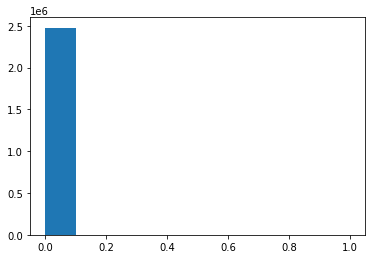

In [40]:
x = DS['FAcc_norm']
fig1 = plt.figure()
plt.hist(x)

x_nonZeros = np.where(x <= 0.0001, 0.0001, x)
# Y = np.max(np.log(x)**2) - np.log(x)**2 
z = np.max(np.log(x_nonZeros)**2) - (np.log(x_nonZeros)**2)
# plt.scatter(x,Y)
fig2 = plt.figure()
plt.scatter(x,z)
